<a href="https://colab.research.google.com/github/pjcroxas/Financial-Data-Science/blob/main/Supervised_ML_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dirs = "/content/drive/My Drive/Data Science Portfolio/2023/Applied/data"
transaction_df1 = pd.read_csv(dirs+"/creditcard_sampledata.csv", index_col=0)
transaction_df2 = pd.read_csv(dirs+"/creditcard_sampledata_2.csv", index_col=0)
transaction_df1.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,-0.715756,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,0.984938,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0



# **Data Preparation**


### **I. Observing Class imbalance: Checking `Fraud` to `Non-fraud`.**

In [ ]:
# Count occurences of fraud and no fraud
occ = transaction_df1["Class"].value_counts()

# Print the ratio of fraud cases
print((occ/len(transaction_df1)*100))

0    99.7875
1     0.2125
Name: Class, dtype: float64


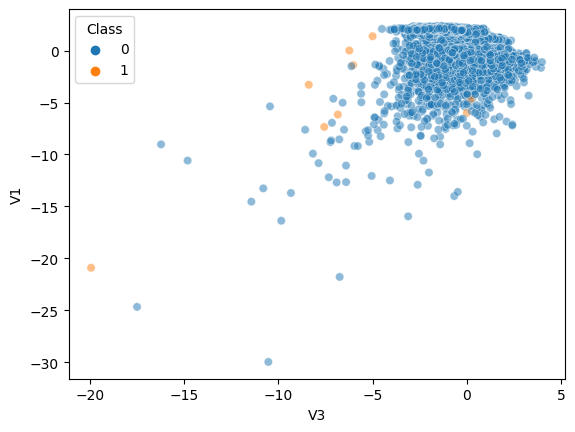

In [ ]:
# Scatterplot from two random variable
sns.scatterplot(x="V3",
                y="V1",
                data=transaction_df1,
                hue="Class",
                alpha=0.5)
plt.show()

We can observed class imbalance of the dataset. To fix this, we will use **Synthetic Minority Oversampling TEchnique** (SMOTE) to create fake data that has near/similar features from minority class.

### **II. SMOTE**

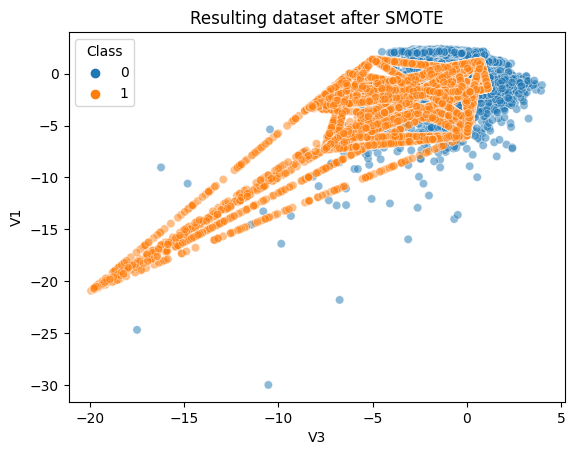

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the dataset into train and test
X = transaction_df1.drop(["Class"], axis=1)
y = transaction_df1["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# SMOTE
method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X, y)
transaction_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Plot the resample data
sns.scatterplot(x="V3",
                y="V1",
                data=transaction_resampled,
                hue="Class",
                alpha=0.5)
plt.title("Resulting dataset after SMOTE")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'SMOTE')

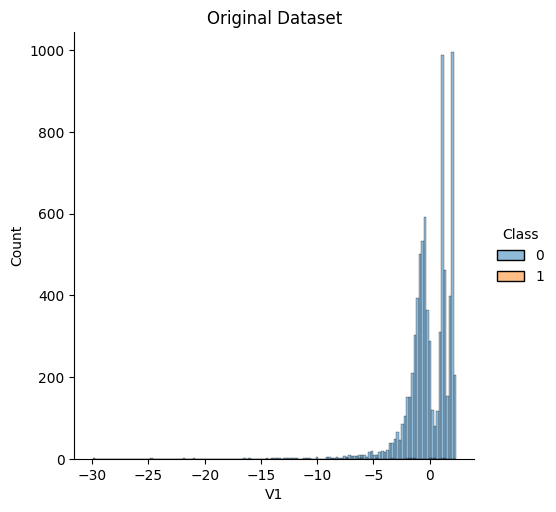

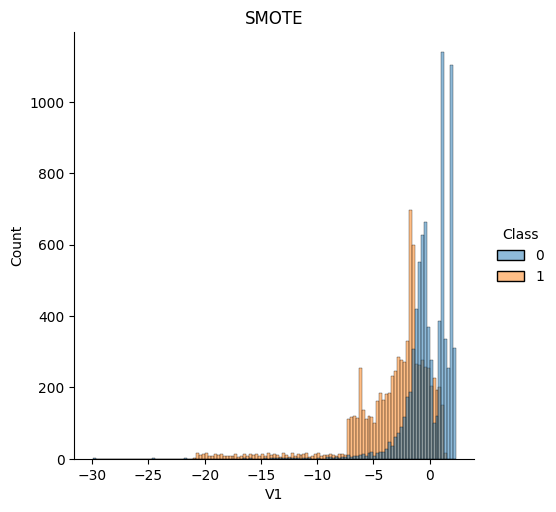

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
sns.displot(ax=axes[0], x="V1", hue="Class", data=transaction_df1)
plt.title("Original Dataset")
sns.displot(ax=axes[1], x="V1", hue="Class", data=transaction_resampled)
plt.title("SMOTE")

# **Baseline Model**

First, we will create a baseline classifier using Random Forest. The model will be the basis on what hyperparameter needs improvement.

### **III. Model Fitting**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = transaction_df2.drop(["Class"], axis=1)
y = transaction_df2["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define Random forest model
model = RandomForestClassifier(random_state=5)

# Fit the model to our training set
model.fit(X_train, y_train)

# Predict & predict probabilities
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the accuracy performance metric
print("Accuracy Score: ",accuracy_score(y_test, predictions))

Accuracy Score:  0.991324200913242


### **IV. Performance Evaluation**

Text(0, 0.5, 'True Positive Rate')

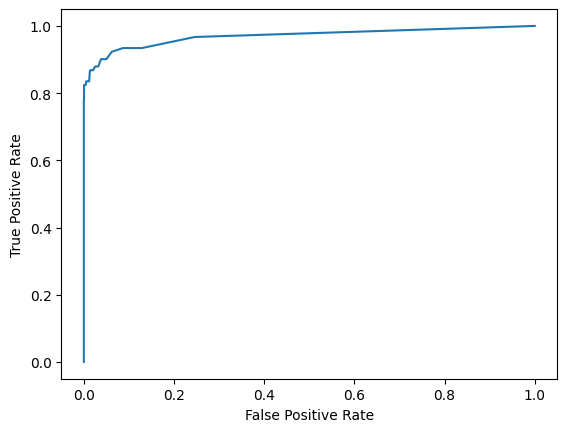

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

# Receiver Operating Curve score
fpr, tpr, _ = roc_curve(y_test, probs[:,1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [ ]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, predictions),
             index=["P+", "P-"],
             columns=["A+", "A-"])

,A+,A-
P+,2098,1
P-,18,73


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190



### **V. Plotting the Precision Recall Curve**

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

Average Precision:  0.7995764694394831


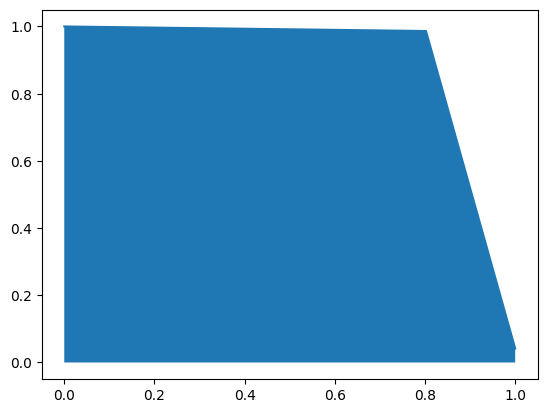

In [ ]:
average_precision = average_precision_score(y_test, predictions)
precision, recall, _ = precision_recall_curve(y_test, predictions)
print("Average Precision: ",average_precision)
plt.plot(recall, precision)
plt.fill_between(recall, precision)

# **Model Adjustment**

###  **VI. Balanced Subsample**

In [ ]:
# Define a balanced subsample model
model_bal_subsample = RandomForestClassifier(class_weight="balanced_subsample",
                               random_state=5)

# Fit the model to the training data
model_bal_subsample.fit(X_train, y_train)

# Predict test data and predict probability
predictions_bal_subsample = model_bal_subsample.predict(X_test)
probs_bal_subsample = model_bal_subsample.predict_proba(X_test)

In [ ]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, predictions_bal_subsample),
             index=["P+", "P-"],
             columns=["A+", "A-"])

,A+,A-
P+,2098,1
P-,17,74


Using a balanced subsample class weight worsened the classifying capability of the model.

In [ ]:
print(classification_report(y_test, predictions_bal_subsample))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.81      0.89        91

    accuracy                           0.99      2190
   macro avg       0.99      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190



`UndefinedMetricWarning` was raised due to the 0 predictions.

### **VII. Utilizing other hyperparameters of RandomForest**

In [ ]:
rfc_model = RandomForestClassifier(
    bootstrap=True,
    class_weight={0:1, 1:12},
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=10,
    n_estimators=20,
    n_jobs=-1,
    random_state = 5
)

def get_model_results(X_train, y_train, X_test, y_test, model):
  model=model
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  clf_matrix = pd.DataFrame(confusion_matrix(y_test, predictions),
             index=["P+", "P-"],
             columns=["A+", "A-"])
  clf_report = classification_report(y_test, predictions)
  return print(clf_report,"\n" ,clf_matrix)

In [ ]:
get_model_results(X_train, y_train, X_test, y_test, rfc_model)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.84      0.88        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190
 
       A+  A-
P+  2094   5
P-    15  76


### **VIII. Hyperparameter Tuning: GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define a parameter grid
param_grid = {
    'n_estimators': [1,30],
    'max_features': ['auto', 'log2'],
    'max_depth':[4,8],
    'criterion':['gini', 'entropy']
}

# Define model
model = RandomForestClassifier(random_state=5)

# Define Grid Search Cross-validation
CV_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

In [ ]:
# Fit the model
CV_model.fit(X_train, y_train)
print("Best Parameters: ", CV_model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 30}


### **IX. Using the Parameters from GridSearchCV**

In [ ]:
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='auto',
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

get_model_results(X_train, y_train, X_test, y_test, model)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.84      0.88        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190
 
       A+  A-
P+  2094   5
P-    15  76
